In [ ]:
! pip install sdv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.0
    Uninstalling packaging-23.0:
      Successfully uninstalled packaging-23.0


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, precision_recall_fscore_support, roc_curve, auc
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
import pickle
import tensorflow as tf
from sdv.tabular import TVAE
from sdv.evaluation import evaluate
import time
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



##Steps
1.	Dataset loading, cleaning, and sampling (10%) of majority classes per file
2.	Feature Selection:

  *   feature selection method 1: Information Gain (IG), used to remove irrelevant features to improve model efficiency

  *   feature selection method 2: Pearson Correlation, used to remove redundant features to improve model efficiency and accuracy

3.	Data Balancing:
  
  Oversampling for miniroty classes using TVAE-GAN



##Reading the dataset

In [ ]:
directory = "/content/drive/MyDrive/Colab Notebooks/CIC-IDS-2018/"

In [ ]:
def read_data(partname):
  dfs = []
  subdirectory = partname
  for filename in os.listdir(subdirectory):
    file_directory = os.path.join(subdirectory, filename)
    if os.path.isfile(file_directory):
      print(filename)
      df = pd.read_csv(file_directory)
      dfs.append(df)

  return pd.concat(dfs)


In [ ]:
df_1 = read_data('dataset-part1')

In [ ]:
df_2 = read_data('dataset-part2')

In [ ]:
df_3 = read_data('dataset-part3')

In [ ]:
df_4 = read_data('dataset-part4')

##Preprocessing
-Drop na, inf

-Drop duplicate rows


In [ ]:
def Preprocessing(df):
    
    # Drop timestamp column
    df.drop(['Timestamp'], axis=1,inplace=True)
    
    #Drop duplicated rows
    df.drop_duplicates(inplace = True)

    # cleanning
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    df = df[indices_to_keep]
  
    return df

In [ ]:
df_1 = Preprocessing(df_1)
df_2 = Preprocessing(df_2)
df_3 = Preprocessing(df_3)
df_4 = Preprocessing(df_4)

##Selecting a subset from the originl dataset

In [ ]:
df_1.Label.value_counts()

In [ ]:
# Randomly sample instances from majority classes and keep the miniroty
df_minor = df_1[(df_1['Label']!='Benign')]
df_BENIGN = df_1[(df_1['Label']=='Benign')]
df_BENIGN = df_BENIGN.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)

df_part_1 = df_BENIGN.append(df_minor)

df_part_1.Label.value_counts()

In [ ]:
df_part_1 = df_part_1.sort_index()

# Save the part 1 sampled dataset
df_part_1.to_csv('CICIDS2018_sample_1.csv',index=0)

In [ ]:
df_2.Label.value_counts()

In [ ]:
# Randomly sample instances from majority classes
df_minor = df_2[(df_2['Label']=='DDOS attack-LOIC-UDP')|(df_2['Label']=='Brute Force -Web')|
                (df_2['Label']=='Brute Force -XSS')|(df_2['Label']=='SQL Injection')]
df_BENIGN = df_2[(df_2['Label']=='Benign')]
df_BENIGN = df_BENIGN.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)
df_DDOS_attack_HOIC = df_2[(df_2['Label']=='DDOS attack-HOIC')]
df_DDOS_attack_HOIC = df_DDOS_attack_HOIC.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)

df_part_2 = df_BENIGN.append(df_DDOS_attack_HOIC).append(df_minor)

df_part_2.Label.value_counts()


In [ ]:
df_part_2 = df_part_2.sort_index()

# Save the part 2 sampled dataset
df_part_2.to_csv('CICIDS2018_sample_2.csv',index=0)


In [ ]:
df_3.Label.value_counts()

In [ ]:
df_3 = df_3[(df_3['Label']!='Label')]

In [ ]:
df_3.Label.value_counts()

In [ ]:
# Randomly sample instances from majority classes
df_BENIGN = df_3[(df_3['Label']=='Benign')]
df_BENIGN = df_BENIGN.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)
df_Bot = df_3[(df_3['Label']=='Bot')]
df_Bot = df_Bot.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)
df_Infilteration = df_3[(df_3['Label']=='Infilteration')]
df_Infilteration = df_Infilteration.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)

df_part_3 = df_BENIGN.append(df_Bot).append(df_Infilteration)

df_part_3.Label.value_counts()


In [ ]:
df_part_3 = df_part_3.sort_index()

# Save the part 2 sampled dataset
df_part_3.to_csv('CICIDS2018_sample_3.csv',index=0)



In [ ]:
df_4.Label.value_counts()

In [ ]:
# Randomly sample instances from majority classes
df_BENIGN = df_4[(df_4['Label']=='Benign')]
df_BENIGN = df_BENIGN.sample(n=None, frac=0.01, replace=False, weights=None, random_state=None, axis=0)
df_DDoS_attacks_LOIC_HTTP = df_4[(df_4['Label']=='DDoS attacks-LOIC-HTTP')]
df_DDoS_attacks_LOIC_HTTP = df_DDoS_attacks_LOIC_HTTP.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)

df_part_4 = df_BENIGN.append(df_DDoS_attacks_LOIC_HTTP)

df_part_4.Label.value_counts()


In [ ]:
df_part_4 = df_part_4.sort_index()

# Save the part 2 sampled dataset
df_part_4.to_csv('CICIDS2018_sample_4.csv',index=0)


##Feature Selection
Feature selection method 1: Information Gain (IG), used to remove irrelevant features to improve model efficiency

Feature selection method 2: Pearson Correlation, used to remove redundant features to improve model efficiency and accuracy


In [ ]:
#Reading the dataset parts into one dataframe

df_1 = pd.read_csv('CICIDS2018_sample_1.csv')
df_2 = pd.read_csv('CICIDS2018_sample_2.csv')
df_3 = pd.read_csv('CICIDS2018_sample_3.csv')
df_4 = pd.read_csv('CICIDS2018_sample_4.csv')

In [ ]:
print('df_1 shape: {}\ndf_2 shape: {}\ndf_3 shape: {}\ndf_4 shape: {}'.format(df_1.shape, df_2.shape,df_3.shape,df_4.shape))

df_1 shape: (293335, 79)
df_2 shape: (97650, 79)
df_3 shape: (101660, 79)
df_4 shape: (130710, 83)


In [ ]:
print(df_4.columns)
print(df_1.columns)

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
       'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
       'D

In [ ]:
#Drop extra columns in part 4 dataset that don't exist in other datasets
df_4= df_4.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1)
df_4.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Siz

In [ ]:
df_4.shape

(130710, 79)

In [ ]:
# Joining all dataset parts into one dataset
data = pd.concat([df_1, df_2, df_3,df_4], axis=0).reset_index(drop=True)

In [ ]:
print('dataset shape:',data.shape)
data.Label.value_counts()

dataset shape: (623355, 79)


Benign                      284017
SSH-Bruteforce               94048
DoS attacks-Hulk             88690
DDoS attacks-LOIC-HTTP       57619
DoS attacks-GoldenEye        41406
DDOS attack-HOIC             19579
Bot                          14454
Infilteration                10929
DoS attacks-Slowloris         9908
DDOS attack-LOIC-UDP          1730
Brute Force -Web               555
Brute Force -XSS               228
SQL Injection                   84
DoS attacks-SlowHTTPTest        55
FTP-BruteForce                  53
Name: Label, dtype: int64

In [ ]:
data.to_csv(directory+'CICIDS2018_sampled-data.csv',index=0)

In [ ]:
data = pd.read_csv(directory+'CICIDS2018_sampled-data.csv')

In [ ]:
data.Label.value_counts()

Benign                      284017
SSH-Bruteforce               94048
DoS attacks-Hulk             88690
DDoS attacks-LOIC-HTTP       57619
DoS attacks-GoldenEye        41406
DDOS attack-HOIC             19579
Bot                          14454
Infilteration                10929
DoS attacks-Slowloris         9908
DDOS attack-LOIC-UDP          1730
Brute Force -Web               555
Brute Force -XSS               228
SQL Injection                   84
DoS attacks-SlowHTTPTest        55
FTP-BruteForce                  53
Name: Label, dtype: int64

In [ ]:
# Label encoding and adding Binary classification column
df = data.copy()
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,6,5234448,5,3,137.0,442.0,137.0,0.0,27.400,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
1,80,6,477161,5,3,211.0,463.0,211.0,0.0,42.200,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
2,80,6,340364,24,24,255.0,45734.0,255.0,0.0,10.625,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
3,80,6,476608,5,3,209.0,461.0,209.0,0.0,41.800,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
4,0,0,112641497,3,0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,56320748.5,91.216775,56320813.0,56320684.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623350,3306,6,19,1,1,0.0,0.0,0.0,0.0,0.000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
623351,5761,6,105744,2,1,0.0,0.0,0.0,0.0,0.000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
623352,445,6,739998,2,2,0.0,0.0,0.0,0.0,0.000,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
623353,23,6,20,1,1,0.0,0.0,0.0,0.0,0.000,...,24.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0


In [ ]:
print(df.Label.value_counts())

0     284017
14     94048
8      88690
6      57619
7      41406
4      19579
1      14454
12     10929
10      9908
5       1730
2        555
3        228
13        84
9         55
11        53
Name: Label, dtype: int64


In [ ]:
#https://github.com/Western-OC2-Lab/AutoML-Implementation-for-Static-and-Dynamic-Data-Analytics/blob/main/AutoML_Online_Learning_Dataset_2.ipynb
# Remove irrelevant features and select important features
def Feature_Importance_IG(data):
    
    features = data.drop(['Label'],axis=1).values  
    labels = data['Label'].values
    
    # Extract feature names
    feature_names = list(data.drop(['Label'],axis=1).columns)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    model = lgb.LGBMRegressor(verbose = -1)
    model.fit(features, labels)
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

    # Sort features according to importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # Normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    cumulative_importance=0.90 # Only keep the important features with cumulative importance scores>=90%. It can be changed.

    # Make sure most important features are on top
    feature_importances = feature_importances.sort_values('cumulative_importance')

    # Identify the features not needed to reach the cumulative_importance
    record_low_importance = feature_importances[feature_importances['cumulative_importance'] > cumulative_importance]

    to_drop = list(record_low_importance['feature'])
    print(feature_importances.drop(['importance'],axis=1))
    return to_drop

In [ ]:
#https://github.com/Western-OC2-Lab/AutoML-Implementation-for-Static-and-Dynamic-Data-Analytics/blob/main/AutoML_Online_Learning_Dataset_2.ipynb
# Remove redundant features
def Feature_Redundancy_Pearson(data):
    correlation_threshold=0.90 # Only remove features with the redundancy>90%
    features = data.drop(['Label'],axis=1)
    corr_matrix = features.corr()

    # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool_))

    # Select the features with correlations above the threshold
    # Need to use the absolute value
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    # Dataframe to hold correlated pairs
    record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

    # Iterate through the columns to drop
    for column in to_drop:

        # Find the correlated features
        corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

        # Find the correlated values
        corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
        drop_features = [column for _ in range(len(corr_features))]    

        # Record the information (need a temp df for now)
        temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                         'corr_feature': corr_features,
                                         'corr_value': corr_values})
        record_collinear = record_collinear.append(temp_df, ignore_index = True)
    print(record_collinear)
    return to_drop

In [ ]:
def Auto_Feature_Engineering(df):
    drop1 = Feature_Importance_IG(df)
    dfh1 = df.drop(columns = drop1)
    
    drop2 = Feature_Redundancy_Pearson(dfh1)
    dfh2 = dfh1.drop(columns = drop2)
    
    return dfh2

In [ ]:
dfh2 = Auto_Feature_Engineering(df)
# 23 remaining features + Label
dfh2

              feature  normalized_importance  cumulative_importance
0            Dst Port               0.102333               0.102333
1   Init Fwd Win Byts               0.080667               0.183000
2        Flow IAT Min               0.055000               0.238000
3         Pkt Len Std               0.038667               0.276667
4    Fwd Seg Size Min               0.035667               0.312333
..                ...                    ...                    ...
63      Bwd URG Flags               0.000000               1.000000
62      Bwd PSH Flags               0.000000               1.000000
61           Protocol               0.000333               1.000000
76   Fwd Seg Size Avg               0.000000               1.000000
77   Subflow Bwd Pkts               0.000000               1.000000

[78 rows x 3 columns]
         drop_feature     corr_feature  corr_value
0     TotLen Fwd Pkts     Tot Fwd Pkts    0.995890
1        Flow IAT Std    Flow Duration   -0.997331
2       

,Dst Port,Flow Duration,Tot Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,...,Bwd IAT Std,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Idle Min,Label
0,80,5234448,5,442.0,137.0,27.400,61.268263,147.333333,255.188819,110.613383,...,438949.262344,0.573126,2.211050e+04,0.0,0.0,29200.0,219.0,32.0,0.0,0
1,80,477161,5,463.0,211.0,42.200,94.362069,154.333333,267.313175,1412.521141,...,168449.805841,6.287186,2.605186e+04,0.0,0.0,14480.0,219.0,32.0,0.0,0
2,80,340364,24,45734.0,255.0,10.625,52.051657,1905.583333,1242.856315,135117.109900,...,28805.553030,70.512745,1.657914e+06,0.0,0.0,26883.0,119.0,32.0,0.0,0
3,80,476608,5,461.0,209.0,41.800,93.467641,153.666667,266.158474,1405.767423,...,168305.556058,6.294481,2.579053e+04,0.0,0.0,14480.0,219.0,32.0,0.0,0
4,0,112641497,3,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.0,0.0,-1.0,-1.0,0.0,56320684.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623350,3306,19,1,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,...,0.000000,52631.578947,0.000000e+00,0.0,0.0,16384.0,0.0,20.0,0.0,0
623351,5761,105744,2,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,...,0.000000,9.456801,0.000000e+00,0.0,0.0,1024.0,0.0,20.0,0.0,0
623352,445,739998,2,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.702710,0.000000e+00,0.0,0.0,8192.0,0.0,32.0,0.0,0
623353,23,20,1,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,...,0.000000,50000.000000,0.000000e+00,0.0,0.0,65067.0,0.0,24.0,0.0,0


In [ ]:
# Remove inf values
indices_to_keep = ~dfh2.isin([np.nan, np.inf, -np.inf]).any(axis=1)
dfh2 = dfh2[indices_to_keep]
dfh2.to_csv(directory+'dataset_FS.csv', index=0)

In [ ]:
df_FS = pd.read_csv(directory+'dataset_FS.csv')

In [ ]:
df_FS.Label.value_counts()

0     283944
14     94048
8      88690
6      57619
7      41406
4      19579
1      14454
12     10925
10      9908
5       1730
2        555
3        228
13        84
9         55
11        53
Name: Label, dtype: int64

#Data Spliting into training and testing

In [ ]:
train_1, test_1 = train_test_split(df_FS, train_size = 0.6, test_size = 0.4, random_state = 0)
train_1.reset_index(inplace=True, drop= True)
test_1.reset_index(inplace=True, drop= True)
print(train_1.shape)
print(test_1.shape)

(373966, 24)
(249312, 24)


In [ ]:
print(train_1.Label.value_counts())
print(test_1.Label.value_counts())

0     170388
14     56433
8      53273
6      34584
7      24762
4      11769
1       8650
12      6587
10      5906
5       1009
2        319
3        150
13        58
9         40
11        38
Name: Label, dtype: int64
0     113556
14     37615
8      35417
6      23035
7      16644
4       7810
1       5804
12      4338
10      4002
5        721
2        236
3         78
13        26
11        15
9         15
Name: Label, dtype: int64


In [ ]:
test_1['Binary'] = np.where(test_1['Label']== 0, 0, 1)

In [ ]:
train_1.to_csv(directory+'train_set.csv', index=0)
test_1.to_csv(directory+'test_set.csv', index=0)

In [ ]:
train_1 = pd.read_csv(directory+'train_set.csv')
test_1 = pd.read_csv(directory+'test_set.csv')

#Data sampling
### Sampling will be only for the train set and the test set will be kept untouched
Oversampling the following miniroty classes using TVAE-GAN model per class


DDOS attack-HOIC             

Bot                          

Infilteration                

DoS attacks-Slowloris         

DDOS attack-LOIC-UDP          

Brute Force -Web               

Brute Force -XSS               

SQL Injection                   

DoS attacks-SlowHTTPTest        

FTP-BruteForce                  

In [ ]:
labels_df ={}
labels_df ={'code': train_1.Label.unique(),
            'label': labelencoder.inverse_transform(train_1.Label.unique()),
            'count': train_1.Label.value_counts(sort =False)
    
}

labels_df = pd.DataFrame(labels_df)
labels_df = labels_df.sort_values('count', ascending=False).reset_index(drop = True)
labels_df

,code,label,count
0,0,Benign,170388
1,14,SSH-Bruteforce,56433
2,8,DoS attacks-Hulk,53273
3,6,DDoS attacks-LOIC-HTTP,34584
4,7,DoS attacks-GoldenEye,24762
5,4,DDOS attack-HOIC,11769
6,1,Bot,8650
7,12,Infilteration,6587
8,10,DoS attacks-Slowloris,5906
9,5,DDOS attack-LOIC-UDP,1009


In [ ]:
# Separate each attack category from the original set and created a distinct subset for training the TVAE-GAN model Labels to oversample
data_DDOS_attack_HOIC = df_FS[(df_FS['Label']==4)]
data_Bot = df_FS[(df_FS['Label']==1)]
data_Infilteration = df_FS[(df_FS['Label']==12)]
data_DoS_attacks_Slowloris = df_FS[(df_FS['Label']==10)]
data_DDOS_attack_LOIC_UDP = df_FS[(df_FS['Label']==5)]
data_Brute_Force_Web = df_FS[(df_FS['Label']==2)]
data_Brute_Force_XSS = df_FS[(df_FS['Label']==3)]
data_SQL_Injection = df_FS[(df_FS['Label']==13)]
data_DoS_attacks_SlowHTTPTest = df_FS[(df_FS['Label']==9)]
data_FTP_BruteForce = df_FS[(df_FS['Label']==11)]

In [ ]:
score_all = evaluate(data_DoS_attacks_SlowHTTPTest,data_FTP_BruteForce).round(3)
print('Similarity between attack class 9 and 11 %s' % score_all)

Similarity between attack class 9 and 11 0.951


In [ ]:
print('Class 9 - DoS_attacks_SlowHTTPTest dataframe\n')
data_DoS_attacks_SlowHTTPTest.head()

Class 9 - DoS_attacks_SlowHTTPTest dataframe



,Dst Port,Flow Duration,Tot Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,...,Bwd IAT Std,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Idle Min,Label
87,21,21,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,47619.04762,0.0,0.0,0.0,26883.0,0.0,40.0,0.0,9
88,21,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,333333.33330,0.0,0.0,0.0,26883.0,0.0,40.0,0.0,9
92,21,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,500000.00000,0.0,0.0,0.0,26883.0,0.0,40.0,0.0,9
101,21,20,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,50000.00000,0.0,0.0,0.0,26883.0,0.0,40.0,0.0,9
113,21,22,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,45454.54545,0.0,0.0,0.0,26883.0,0.0,40.0,0.0,9


In [ ]:
print('Class 11 - FTP_BruteForce dataframe\n')
data_FTP_BruteForce.head()

Class 11 - FTP_BruteForce dataframe



,Dst Port,Flow Duration,Tot Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,...,Bwd IAT Std,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Idle Min,Label
80,21,19,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,52631.578947,0.0,0.0,0.0,26883.0,0.0,40.0,0.0,11
83,21,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,333333.333333,0.0,0.0,0.0,26883.0,0.0,40.0,0.0,11
86,21,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,500000.000000,0.0,0.0,0.0,26883.0,0.0,40.0,0.0,11
94,21,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1000000.000000,0.0,0.0,0.0,26883.0,0.0,40.0,0.0,11
99,21,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,250000.000000,0.0,0.0,0.0,26883.0,0.0,40.0,0.0,11


In [ ]:
def gan_train(data, attackName):
  TVAE_model = TVAE(epochs=100)
  TVAE_model.fit(data)
  TVAE_model.save(directory+'TVAE_model_'+ attackName +'.pkl')
  

In [ ]:
# Train a GAN model for each attack class
gan_train(data_DDOS_attack_HOIC,'DDOS_attack_HOIC')
gan_train(data_Bot,'Bot')
gan_train(data_Infilteration,'Infilteration')
gan_train(data_DoS_attacks_Slowloris,'DoS_attacks_Slowloris')
gan_train(data_DDOS_attack_LOIC_UDP,'DDOS_attack_LOIC_UDP')
gan_train(data_Brute_Force_Web, 'Brute_Force_Web')
gan_train(data_Brute_Force_XSS, 'Brute_Force_XSS')
gan_train(data_SQL_Injection, 'SQL_Injection')
gan_train(data_DoS_attacks_SlowHTTPTest,'DoS_attacks_SlowHTTPTest')
gan_train(data_FTP_BruteForce,'FTP_BruteForce')

In [ ]:
trained_TVAE_names = {
  'DDOS_attack_HOIC': 10000,
  'Bot': 10000,
  'Infilteration': 10000,
  'DoS_attacks_Slowloris': 15000,
  'DDOS_attack_LOIC_UDP': 15000,
  'Brute_Force_Web': 15000,
  'Brute_Force_XSS': 20000,
  'SQL_Injection': 20000,
  'DoS_attacks_SlowHTTPTest': 20000,
  'FTP_BruteForce': 20000 
}

In [ ]:
def load_trained_TVAE():
  trained_TVAE = []
  for attack, count in trained_TVAE_names.items():
      path = directory + 'TVAE_model_' + attack + '.pkl'
      print(path)
      model = TVAE.load(path)
      trained_TVAE.append(model)
  return trained_TVAE
      

In [ ]:
trained_TVAE = load_trained_TVAE()

/content/drive/MyDrive/Colab Notebooks/CIC-IDS-2018/TVAE_model_DDOS_attack_HOIC.pkl
/content/drive/MyDrive/Colab Notebooks/CIC-IDS-2018/TVAE_model_Bot.pkl
/content/drive/MyDrive/Colab Notebooks/CIC-IDS-2018/TVAE_model_Infilteration.pkl
/content/drive/MyDrive/Colab Notebooks/CIC-IDS-2018/TVAE_model_DoS_attacks_Slowloris.pkl
/content/drive/MyDrive/Colab Notebooks/CIC-IDS-2018/TVAE_model_DDOS_attack_LOIC_UDP.pkl
/content/drive/MyDrive/Colab Notebooks/CIC-IDS-2018/TVAE_model_Brute_Force_Web.pkl
/content/drive/MyDrive/Colab Notebooks/CIC-IDS-2018/TVAE_model_Brute_Force_XSS.pkl
/content/drive/MyDrive/Colab Notebooks/CIC-IDS-2018/TVAE_model_SQL_Injection.pkl
/content/drive/MyDrive/Colab Notebooks/CIC-IDS-2018/TVAE_model_DoS_attacks_SlowHTTPTest.pkl
/content/drive/MyDrive/Colab Notebooks/CIC-IDS-2018/TVAE_model_FTP_BruteForce.pkl


In [ ]:
def sample_attacks(trained_TVAE, count):
  samples = trained_TVAE.sample(count)
  return samples

In [ ]:
attack_counts = []
sampled_attacks = []
for count in trained_TVAE_names.values():
  attack_counts.append(count)
index= 0
for model in trained_TVAE:
  samples = sample_attacks(model, attack_counts[index] )
  sampled_attacks.append(samples)
  index+=1

In [ ]:
sampled_attacks_df = pd.concat(sampled_attacks)
sampled_attacks_df.Label.value_counts()

3     20000
13    20000
9     20000
11    20000
10    15000
5     15000
2     15000
4     10000
1     10000
12    10000
Name: Label, dtype: int64

In [ ]:
sampled_attacks_df.shape

(155000, 24)

In [ ]:
sampled_attacks_df.to_csv(directory + 'sampled_attacks_df.csv')

In [ ]:
# Append the sampled data with the train data
train_balanced = train_1.append(sampled_attacks_df).reset_index(drop=True)

In [ ]:
train_balanced['Binary'] = np.where(train_balanced['Label']== 0, 0, 1)

In [ ]:
print(train_balanced['Label'].value_counts())
print(train_balanced['Binary'].value_counts())

0     170388
14     56433
8      53273
6      34584
7      24762
4      21769
10     20906
3      20150
13     20058
9      20040
11     20038
1      18650
12     16587
5      16009
2      15319
Name: Label, dtype: int64
1    358578
0    170388
Name: Binary, dtype: int64


In [ ]:
train_balanced

,Dst Port,Flow Duration,Tot Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,...,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Idle Min,Label,Binary
0,22,367965,22,2665.0,640.0,88.363636,137.869001,133.25,268.771254,12525.647820,...,54.352996,42965.631229,0.0,0.0,26883.0,230.0,32.0,0.0,14,1
1,5355,406684,2,0.0,22.0,22.000000,0.000000,0.00,0.000000,108.192110,...,0.000000,0.000000,0.0,0.0,-1.0,-1.0,8.0,0.0,0,0
2,80,57443,3,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,225.0,-1.0,32.0,0.0,8,1
3,53,1834,1,135.0,37.0,37.000000,0.000000,135.00,0.000000,93784.078517,...,545.256270,3201.333333,0.0,0.0,-1.0,-1.0,8.0,0.0,0,0
4,55950,1444,5,340.0,935.0,187.000000,418.144712,170.00,240.416306,882963.988900,...,1385.041551,112374.553600,0.0,1.0,65535.0,32768.0,20.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528961,21,37,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,27489.403843,0.000000,0.0,0.0,26883.0,0.0,40.0,0.0,11,1
528962,21,34,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,50135.429209,0.000000,0.0,0.0,26883.0,0.0,40.0,0.0,11,1
528963,21,27,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,31396.766225,0.000000,0.0,0.0,26883.0,0.0,40.0,0.0,11,1
528964,21,31,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,38244.822943,0.000000,0.0,0.0,26883.0,0.0,40.0,0.0,11,1


In [ ]:
train_balanced.isna().sum()

Dst Port             0
Flow Duration        0
Tot Fwd Pkts         0
TotLen Bwd Pkts      0
Fwd Pkt Len Max      0
Fwd Pkt Len Mean     0
Fwd Pkt Len Std      0
Bwd Pkt Len Mean     0
Bwd Pkt Len Std      0
Flow Byts/s          0
Flow Pkts/s          0
Flow IAT Mean        0
Bwd IAT Tot          0
Bwd IAT Mean         0
Bwd IAT Std          0
Bwd Pkts/s           0
Pkt Len Var          0
FIN Flag Cnt         0
RST Flag Cnt         0
Init Fwd Win Byts    0
Init Bwd Win Byts    0
Fwd Seg Size Min     0
Idle Min             0
Label                0
Binary               0
dtype: int64

In [ ]:
train_balanced.to_csv(directory + 'train_balanced.csv',index=0)

### Train Baseline Random Forest Model


*   On the original dataset without feature selection
*   On the imbalanced dataset with feature selection
*   On the balanced dataset






In [ ]:
# Random Forest training and prediction (Baseline model)
def RF_train(X_train, y_train, X_test, y_test, filename ):
    rf = RandomForestClassifier(n_estimators=200,random_state = 0)
    rf.fit(X_train,y_train) 
    with open(filename, 'wb') as file:
        pickle.dump(rf, file)
    rf_score=rf.score(X_test,y_test)
    y_predict=rf.predict(X_test)
    y_true = y_test
    print('Accuracy of RF: '+ str(rf_score))
    precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
    print('Precision of RF: '+(str(precision)))
    print('Recall of RF: '+(str(recall)))
    print('F1-score of RF: '+(str(fscore)))
    print(classification_report(y_true,y_predict))
    cm=confusion_matrix(y_true,y_predict)
    f,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()

In [ ]:
df_org = pd.read_csv(directory + 'CICIDS2018_sampled-data.csv')


In [ ]:
df_org.shape

(623355, 79)

In [ ]:
df_org.Label.value_counts()

Benign                      284017
SSH-Bruteforce               94048
DoS attacks-Hulk             88690
DDoS attacks-LOIC-HTTP       57619
DoS attacks-GoldenEye        41406
DDOS attack-HOIC             19579
Bot                          14454
Infilteration                10929
DoS attacks-Slowloris         9908
DDOS attack-LOIC-UDP          1730
Brute Force -Web               555
Brute Force -XSS               228
SQL Injection                   84
DoS attacks-SlowHTTPTest        55
FTP-BruteForce                  53
Name: Label, dtype: int64

In [ ]:
# Enode the target variable
labelencoder = LabelEncoder()
df_org.iloc[:, -1] = labelencoder.fit_transform(df_org.iloc[:, -1])

# cleanning
df_org.dropna(inplace=True)
indices_to_keep = ~df_org.isin([np.nan, np.inf, -np.inf]).any(axis=1)
df_org = df_org[indices_to_keep]


### split train set and test set

In [ ]:
X_org = df_org.drop(['Label'],axis=1).values 
y_org = df_org.iloc[:, -1].values.reshape(-1,1)
y_org = np.ravel(y_org)
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X_org,y_org, train_size = 0.8, test_size = 0.2, random_state = 0)
print(X_train_org.shape)
print(X_test_org.shape)

(498622, 78)
(124656, 78)


Training Random Forest model on the original dataset without Feature selection or class balancing:
Results......

Accuracy of RF: 0.9789260043640098
Precision of RF: 0.9716257656730877
Recall of RF: 0.9789260043640098
F1-score of RF: 0.9745680268458274
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     56790
           1       1.00      1.00      1.00      2942
           2       0.89      0.69      0.78       117
           3       0.85      0.70      0.77        40
           4       1.00      1.00      1.00      3935
           5       0.98      0.98      0.98       366
           6       1.00      1.00      1.00     11522
           7       1.00      1.00      1.00      8312
           8       1.00      1.00      1.00     17601
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00      1985
          11       0.00      0.00      0.00         8
          12       0.27      0.10      0.15 

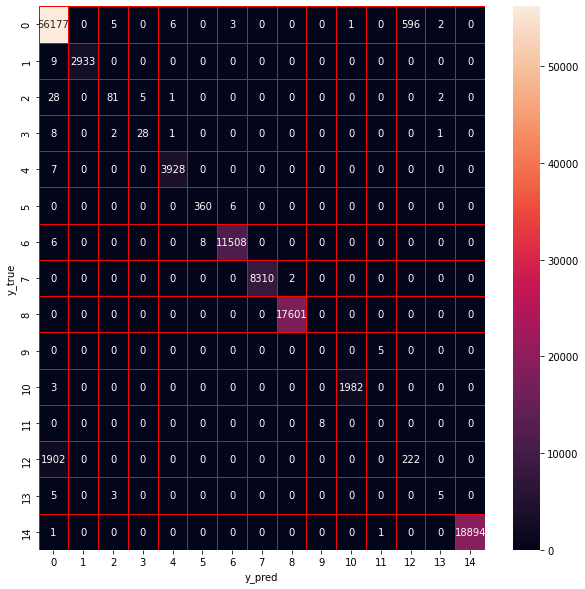

In [ ]:
print('Training Random Forest model on the original dataset without Feature selection or class balancing:')
print('Results......\n')


RF_train(X_train_org, y_train_org, X_test_org, y_test_org, directory + 'RF_originalData.pkl')


In [ ]:
df_FS = pd.read_csv(directory + 'dataset_FS.csv')


In [ ]:

X_FS = df_FS.drop(['Label'],axis=1).values 
y_FS = df_FS.iloc[:, -1].values.reshape(-1,1)
y_FS = np.ravel(y_FS)

X_train_FS, X_test_FS, y_train_FS, y_test_FS = train_test_split(X_FS,y_FS, train_size = 0.8, test_size = 0.2, random_state = 0)
print(X_train_FS.shape)
print(X_test_FS.shape)

(498622, 23)
(124656, 23)


In [ ]:
print(pd.Series(y_train_FS).value_counts())
print(pd.Series(y_test_FS).value_counts())

0     227154
14     75152
8      71089
6      46097
7      33094
4      15644
1      11512
12      8801
10      7923
5       1364
2        438
3        188
13        71
9         50
11        45
dtype: int64
0     56790
14    18896
8     17601
6     11522
7      8312
4      3935
1      2942
12     2124
10     1985
5       366
2       117
3        40
13       13
11        8
9         5
dtype: int64


Training Random Forest model on the dataset with Feature selection but without class balancing:
Results......

Accuracy of RF: 0.9793591965087922
Precision of RF: 0.9718890628451883
Recall of RF: 0.9793591965087922
F1-score of RF: 0.9748966608267805
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     56790
           1       1.00      1.00      1.00      2942
           2       0.91      0.76      0.83       117
           3       0.97      0.85      0.91        40
           4       1.00      1.00      1.00      3935
           5       0.98      0.98      0.98       366
           6       1.00      1.00      1.00     11522
           7       1.00      1.00      1.00      8312
           8       1.00      1.00      1.00     17601
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00      1985
          11       0.00      0.00      0.00         8
          12       0.27      0.10      0.15    

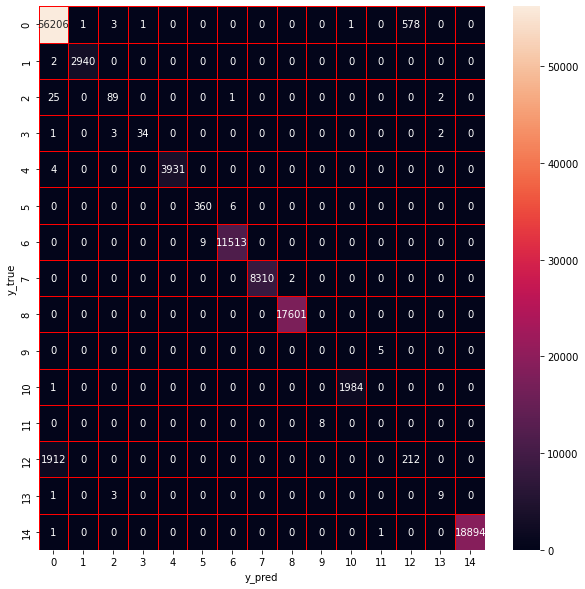

In [ ]:
print('Training Random Forest model on the dataset with Feature selection but without class balancing:')
print('Results......\n')
RF_train(X_train_FS, y_train_FS, X_test_FS, y_test_FS, directory + 'RF_FSData.pkl')

In [ ]:
train = pd.read_csv(directory + 'train_balanced.csv')
test = pd.read_csv(directory + 'test_set.csv')


In [ ]:
print('train shape: ',train.shape)
print('test shape: ',test.shape)

train shape:  (528966, 25)
test shape:  (249312, 25)


In [ ]:
train_balanced_multi = train.drop(['Binary'], axis=1)
test_balanced_multi = test.drop(['Binary'], axis=1)

In [ ]:
# Multiclass dataset split
X_train_m = train_balanced_multi.drop(['Label'],axis=1)
y_train_m = train_balanced_multi.iloc[:, -1].values.reshape(-1,1)
y_train_m = np.ravel(y_train_m)
X_test_m = test_balanced_multi.drop(['Label'],axis=1) 
y_test_m = test_balanced_multi.iloc[:, -1].values.reshape(-1,1)
y_test_m = np.ravel(y_test_m)

print(X_train_m.shape)
print(X_test_m.shape)

(528966, 23)
(249312, 23)


Training Random Forest model on the balanced dataset with Feature selection:
Results......

Accuracy of RF: 0.9791024900526248
Precision of RF: 0.9717816396393639
Recall of RF: 0.9791024900526248
F1-score of RF: 0.9746888607802685
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    113556
           1       1.00      1.00      1.00      5804
           2       0.93      0.76      0.84       236
           3       1.00      0.91      0.95        78
           4       1.00      1.00      1.00      7810
           5       0.97      0.99      0.98       721
           6       1.00      1.00      1.00     23035
           7       1.00      1.00      1.00     16644
           8       1.00      1.00      1.00     35417
           9       0.19      0.20      0.19        15
          10       1.00      1.00      1.00      4002
          11       0.18      0.20      0.19        15
          12       0.28      0.11      0.16      4338
          13

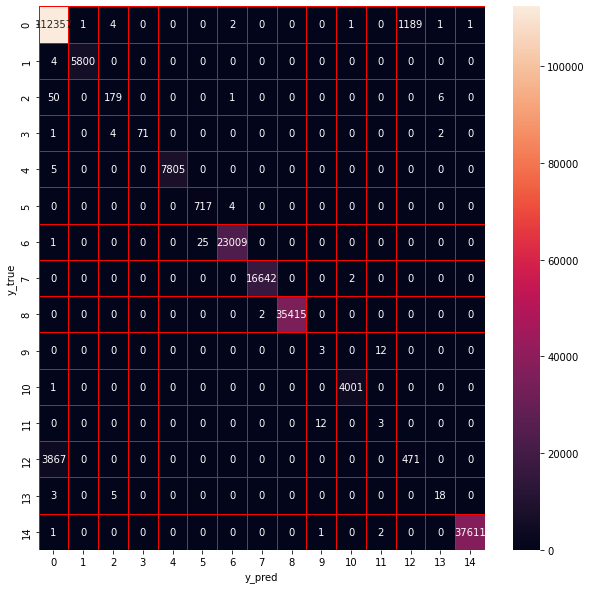

time to train:  4.0 min


In [ ]:
print('Training Random Forest model on the balanced dataset with Feature selection:')
print('Results......\n')
start = time.time()

with tf.device("/GPU:0"):
  RF_train(X_train_m, y_train_m, X_test_m, y_test_m, directory + 'RF_Multi_balanced_data.pkl')

end = time.time()

print("time to train: ",(end-start)//60, 'min')

In [ ]:
train_balanced_binary = train.drop(['Label'], axis=1)
test_balanced_binary = test.drop(['Label'], axis=1)

In [ ]:
# Binary dataset split
X_train_b = train_balanced_binary.drop(['Binary'],axis=1).values 
y_train_b = train_balanced_binary.iloc[:, -1].values.reshape(-1,1)
y__train_b = np.ravel(y_train_b)

X_test_b = test_balanced_binary.drop(['Binary'],axis=1).values 
y_test_b = test_balanced_binary.iloc[:, -1].values.reshape(-1,1)
y__test_b = np.ravel(y_test_b)

print(X_train_b.shape)
print(X_test_b.shape)

(556294, 23)
(186984, 23)


Training Random Forest Binary classifier on the balanced dataset with Feature selection:
Results......

Accuracy of RF: 0.9793404783296966
Precision of RF: 0.9796030062519109
Recall of RF: 0.9793404783296966
F1-score of RF: 0.9793577610241887
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85264
           1       0.99      0.97      0.98    101720

    accuracy                           0.98    186984
   macro avg       0.98      0.98      0.98    186984
weighted avg       0.98      0.98      0.98    186984



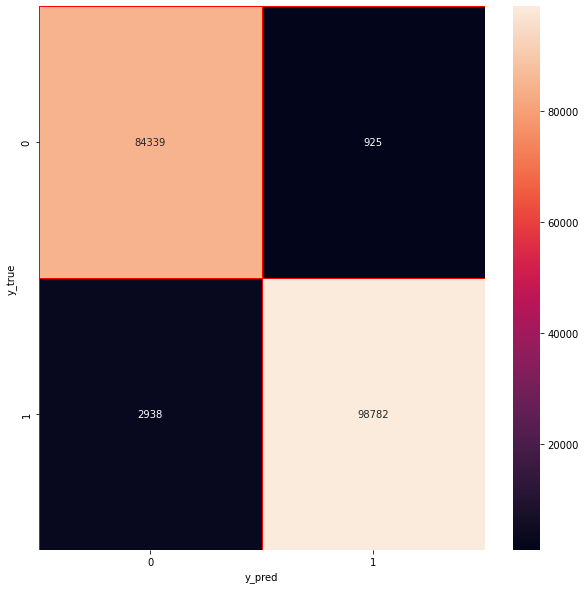

time to train:  4.0 min


In [ ]:
print('Training Random Forest Binary classifier on the balanced dataset with Feature selection:')
print('Results......\n')
start = time.time()
#with tf.device("/GPU:0"):
RF_train(X_train_b, y_train_b, X_test_b, y_test_b, directory + 'RF_Binary_balanced_data.pkl')
    
end = time.time()
print("time to train: ",(end-start)//60, 'min')

## Stacked Ensemble Learner


*   LogisticRegression
*   ExtraTreesClassifier 
*   GradientBoostingClassifier
*   XGBClassifier
*   MLPClassifier 



In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score


In [ ]:
# Loading the balanced dataset and the test set
train = pd.read_csv(directory + 'train_balanced.csv')
test = pd.read_csv(directory + 'test_set.csv')

In [ ]:
train_balanced_binary = train.drop(['Label'], axis=1)
test_balanced_binary = test.drop(['Label'], axis=1)

In [ ]:
# Binary dataset split
X_train_sk = train_balanced_binary.drop(['Binary'],axis=1) 
y_train_sk = train_balanced_binary.iloc[:, -1].values.reshape(-1,1)
y_train_sk = np.ravel(y_train_sk)

X_test_sk = test_balanced_binary.drop(['Binary'],axis=1) 
y_test_sk = test_balanced_binary.iloc[:, -1].values.reshape(-1,1)
y_test_sk = np.ravel(y_test_sk)

print(X_train_sk.shape)
print(X_test_sk.shape)

(528966, 23)
(249312, 23)


In [ ]:
X_train_sk

,Dst Port,Flow Duration,Tot Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,...,Bwd IAT Mean,Bwd IAT Std,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Idle Min
0,22,367965,22,2665.0,640.0,88.363636,137.869001,133.25,268.771254,12525.647820,...,19366.157895,48485.854616,54.352996,42965.631229,0.0,0.0,26883.0,230.0,32.0,0.0
1,5355,406684,2,0.0,22.0,22.000000,0.000000,0.00,0.000000,108.192110,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-1.0,-1.0,8.0,0.0
2,80,57443,3,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,225.0,-1.0,32.0,0.0
3,53,1834,1,135.0,37.0,37.000000,0.000000,135.00,0.000000,93784.078517,...,0.000000,0.000000,545.256270,3201.333333,0.0,0.0,-1.0,-1.0,8.0,0.0
4,55950,1444,5,340.0,935.0,187.000000,418.144712,170.00,240.416306,882963.988900,...,923.000000,0.000000,1385.041551,112374.553600,0.0,1.0,65535.0,32768.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528961,21,37,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,27489.403843,0.000000,0.0,0.0,26883.0,0.0,40.0,0.0
528962,21,34,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,50135.429209,0.000000,0.0,0.0,26883.0,0.0,40.0,0.0
528963,21,27,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,31396.766225,0.000000,0.0,0.0,26883.0,0.0,40.0,0.0
528964,21,31,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,38244.822943,0.000000,0.0,0.0,26883.0,0.0,40.0,0.0


In [ ]:
print(pd.Series(y_train_sk).value_counts())
print(pd.Series(y_test_sk).value_counts())

1    358578
0    170388
dtype: int64
1    135756
0    113556
dtype: int64


## Stacking model training

In [ ]:

# Define the base models
level0 = list()

level0.append(('LR', LogisticRegression()))
# level0.append(('ETC', ExtraTreesClassifier()))
# level0.append(('GBC', GradientBoostingClassifier()))
level0.append(('DT', DecisionTreeClassifier()))

# define meta learner model
level1 = XGBClassifier()

# define the stacking ensemble - the stacked model is assessed using 5 cross validations
stack_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, n_jobs=-1, verbose=2)

# fit the model on training data
start = time.time()
with tf.device("/GPU:0"):
    stack_model.fit(X_train_sk, y_train_sk)
#Calculate training time
end = time.time()
print("time to train: ",(end-start)//60, 'min')


time to train:  1.0 min


In [ ]:
#Save the trained EL model
Pkl_Filename = directory + "stackML_binary.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(stack_model, file)

## Stacking model evaluation

Model performance for Training set
- Accuracy: 0.9921998767406601
- F1 score: 0.9921841046393292
- Precision: 0.9922226913096822
- Recall: 0.9921998767406601
----------------------------------
Model performance for Test set
- Accuracy: 0.9613817225003208
- F1 score: 0.9613430106540393
- Precision: 0.9614994897835176
- Recall: 0.9613817225003208
- Classification report for Test set:

              precision    recall  f1-score   support

      Benign       0.97      0.95      0.96    113556
   Malicious       0.96      0.97      0.96    135756

    accuracy                           0.96    249312
   macro avg       0.96      0.96      0.96    249312
weighted avg       0.96      0.96      0.96    249312



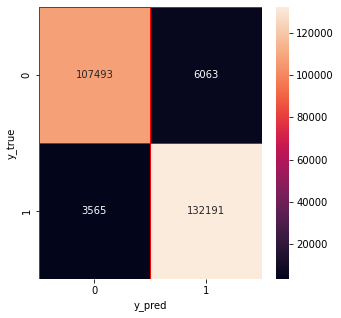

In [ ]:
# Make predictions
y_train_pred_sk = stack_model.predict(X_train_sk)
y_test_pred_sk = stack_model.predict(X_test_sk)

# Training set model performance
accuracy_train = accuracy_score(y_train_sk, y_train_pred_sk) # Calculate Accuracy
precision_train,recall_train,fscore_train,none = precision_recall_fscore_support(y_train_sk, y_train_pred_sk, average='weighted') 

# Test set model performance
accuracy_test = accuracy_score(y_test_sk, y_test_pred_sk) # Calculate Accuracy
precision_test,recall_test,fscore_test,none = precision_recall_fscore_support(y_test_sk, y_test_pred_sk, average='weighted')

print('Model performance for Training set')
print('- Accuracy: %s' % accuracy_train)
print('- F1 score: %s' % fscore_train)
print('- Precision: %s' % precision_train)
print('- Recall: %s' % recall_train)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % accuracy_test)
print('- F1 score: %s' % fscore_test)
print('- Precision: %s' % precision_test)
print('- Recall: %s' % recall_test)


print('- Classification report for Test set:\n')

print(classification_report(y_test_sk,y_test_pred_sk, target_names=['Benign', 'Malicious']))
cm=confusion_matrix(y_test_sk,y_test_pred_sk)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:

fpr, tpr, _ = roc_curve(y_test_sk, y_test_pred_sk) 
print('Ensemble model')
print('False Positive Rate: %s' % fpr[1].round(3),'\nTrue Positive Rate: %s ' % tpr[1].round(3))

Ensemble model
False Positive Rate: 0.053 
True Positive Rate: 0.974 


### Comparing the performance of different stacking model base learners and the final stacking model

In [ ]:
models = dict()
models['LogisticRegression'] = LogisticRegression()
# models['ExtraTreesClassifier'] = ExtraTreesClassifier()
# models['GradientBoostingClassifier'] = GradientBoostingClassifier()
models['DecisionTreeClassifier'] = DecisionTreeClassifier()


In [ ]:

for name, model in models.items():
    with tf.device("/GPU:0"):
        y_pred = model.fit(X_train_sk, y_train_sk).predict(X_test_sk)
        scores = accuracy_score(y_test_sk, y_test_pred_sk)
        print('>%s %.3f' % (name, scores.mean()))


>LogisticRegression 0.961
>DecisionTreeClassifier 0.961


In [ ]:
pred_LR = models['LogisticRegression'].predict(X_test_sk)
# pred_ETC = models['ExtraTreesClassifier'].predict(X_test)
# pred_GBC = models['GradientBoostingClassifier'].predict(X_test)
pred_DT = models['DecisionTreeClassifier'].predict(X_test_sk)


scores_LR = accuracy_score(y_test_sk, pred_LR)
f1_s_LR = f1_score(y_test_sk, pred_LR, average='weighted')

# scores_ETC = accuracy_score(y_test, pred_ETC)
# f1_s_ETC = f1_score(y_test, pred_ETC, average='weighted')

# scores_GBC = accuracy_score(y_test, pred_GBC)
# f1_s_GBC = f1_score(y_test, pred_GBC, average='weighted')

scores_DT = accuracy_score(y_test_sk, pred_DT)
f1_s_DT = f1_score(y_test_sk, pred_DT, average='weighted')


In [ ]:
# model performance for comparison
models_accuracy = {'LogisticRegression': scores_LR.round(3),
#                   'ExtraTreesClassifier': scores_ETC.round(3),
#                   'GradientBoostingClassifier': scores_GBC.round(3),
                  'DecisionTreeClassifier': scores_DT.round(3),
                  'Stack Ensemble': accuracy_test.round(3)
 }

models_f1_score = {'LogisticRegression': f1_s_LR.round(3),
#                   'ExtraTreesClassifier': f1_s_ETC.round(3),
#                   'GradientBoostingClassifier': f1_s_GBC.round(3),
                  'DecisionTreeClassifier': f1_s_DT.round(3),
                  'Stack Ensemble': fscore_test.round(3)
}
acc_df = pd.DataFrame.from_dict(models_accuracy, orient='index', columns=['Accuracy'])
f1_df = pd.DataFrame.from_dict(models_f1_score, orient='index', columns=['F1_score'])
results_df = pd.concat([acc_df,  f1_df], axis=1)
results_df

,Accuracy,F1_score
LogisticRegression,0.807,0.806
DecisionTreeClassifier,0.970,0.970
Stack Ensemble,0.961,0.961


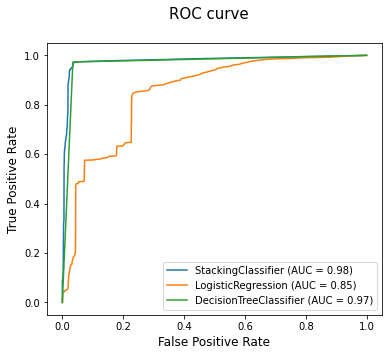

In [ ]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(6,5))
stk_disp = RocCurveDisplay.from_estimator(stack_model, X_test_sk, y_test_sk,ax=ax)
LR_disp = RocCurveDisplay.from_estimator(models['LogisticRegression'], X_test_sk, y_test_sk,ax=ax)
# ETC_disp = RocCurveDisplay.from_estimator(models['ExtraTreesClassifier'], X_test, y_test,ax=ax)
# GBC_disp = RocCurveDisplay.from_estimator(models['GradientBoostingClassifier'], X_test, y_test,ax=ax)
DT_disp = RocCurveDisplay.from_estimator(models['DecisionTreeClassifier'], X_test_sk, y_test_sk,ax=ax)
stk_disp.figure_.suptitle("ROC curve", fontsize=15 )

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

plt.legend()
plt.show()

## Testing the full multi-stage model 
Stacking model ---> Random Forest

In [ ]:
# Load the stacking model to perform binary classification
with open(directory + 'stackML_binary.pkl', 'rb') as f:
  stk_model = pickle.load(f)

# Load the random forest model to perform multiclass classification
with open(directory + 'RF_Multi_balanced_data.pkl', 'rb') as f:
  rf_model = pickle.load(f)

# prform binary prediction on the test set
pred = stk_model.predict(X_test_sk)


In [ ]:
acc_test = accuracy_score(y_test_sk, pred) 
print('- Stacking model accuracy: %s' % acc_test.round(3))

- Stacking model accuracy: 0.961


In [ ]:
# Append the prediction and encoded multiclass labels (test['Label']) with the test set
X_test_pred =pd.concat([ X_test_sk ,pd.DataFrame(pred,columns=['prediction'])], axis=1)
X_test_pred['label'] = pd.Series(test['Label'].tolist())
X_test_pred['binary'] = pd.Series(test['Binary'].tolist())
X_test_pred

,Dst Port,Flow Duration,Tot Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,...,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Idle Min,prediction,label,binary
0,443,342670,8,6955.0,608.0,116.625000,212.579355,632.272727,617.839314,23019.231330,...,290990.778947,0.0,0.0,8192.0,132.0,20.0,0.0,0,0,0
1,22,329051,22,2665.0,640.0,86.909091,137.688022,126.904762,263.574639,13909.697889,...,42228.115751,0.0,0.0,26883.0,230.0,32.0,0.0,1,14,1
2,22,391456,22,2665.0,640.0,87.636364,137.780552,133.250000,268.771254,11733.119431,...,42967.916944,0.0,0.0,26883.0,230.0,32.0,0.0,1,14,1
3,80,115109301,16,706.0,434.0,27.812500,108.317569,50.428571,188.686437,9.999192,...,21468.916129,0.0,0.0,8192.0,172.0,20.0,9952914.0,0,0,0
4,443,5919319,8,3197.0,201.0,44.750000,76.734701,532.833333,725.922425,600.575843,...,253784.857143,0.0,0.0,8192.0,60.0,20.0,5563084.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249307,50278,1,2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,180.0,-1.0,20.0,0.0,0,0,0
249308,53,851,1,71.0,43.0,43.000000,0.000000,71.000000,0.000000,133960.047000,...,261.333333,0.0,0.0,-1.0,-1.0,8.0,0.0,0,0,0
249309,22,430335,22,2665.0,640.0,89.090909,137.953377,121.136364,258.641560,10747.440947,...,41512.676768,0.0,0.0,26883.0,230.0,32.0,0.0,1,14,1
249310,445,187292,5,131.0,53.0,10.600000,23.702321,65.500000,92.630988,982.423168,...,2248.285714,0.0,1.0,8192.0,2240.0,20.0,0.0,0,12,1


In [ ]:
# Drop all rows where row for prediction == 0 (benign)
X_test_all = X_test_pred[(X_test_pred['prediction']!=0)]

# Create X and y out of the test set
X_test_rf = X_test_all.drop(axis=1, columns=['label', 'prediction', 'binary'])
y_test_rf = X_test_all['label']


In [ ]:
print('True Binary labels:\n', pd.Series(y_test_sk).value_counts())
print('Predicted Binary labels:\n',X_test_pred.prediction.value_counts())
print('True Multiclass labels after droping all rows where row prediction == 0 (benign):\n',X_test_all.label.value_counts())

True Binary labels:
 1    135756
0    113556
dtype: int64
Predicted Binary labels:
 1    138254
0    111058
Name: prediction, dtype: int64
True Multiclass labels after droping all rows where row prediction == 0 (benign):
 14    37614
8     35413
6     23027
7     16642
4      7808
0      6063
1      5798
10     4000
12      833
5       721
2       202
3        78
13       25
11       15
9        15
Name: label, dtype: int64


In [ ]:
multi_labels = [
        'Benign',
        'Bot',                    
        'Brute Force -Web',           
        'Brute Force -XSS',           
        'DDOS attack-HOIC',    
        'DDOS attack-LOIC-UDP',       
        'DDoS attacks-LOIC-HTTP',       
        'DoS attacks-GoldenEye',                       
        'DoS attacks-Hulk',             
        'DoS attacks-SlowHTTPTest',         
        'DoS attacks-Slowloris',          
        'FTP-BruteForce',               
        'Infilteration',               
        'SQL Injection',                   
        'SSH-Bruteforce'       
                        
    ]
  

In [ ]:
# Run prediction
y_predict = rf_model.predict(X_test_rf)

Accuracy of RF: 0.9889695777337365
Precision of RF: 0.9911810928587832
Recall of RF: 0.9889695777337365
F1-score of RF: 0.9899055593391232
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      6063
           1       1.00      1.00      1.00      5798
           2       0.93      0.88      0.91       202
           3       1.00      0.91      0.95        78
           4       1.00      1.00      1.00      7808
           5       0.97      0.99      0.98       721
           6       1.00      1.00      1.00     23027
           7       1.00      1.00      1.00     16642
           8       1.00      1.00      1.00     35413
           9       0.19      0.20      0.19        15
          10       1.00      1.00      1.00      4000
          11       0.18      0.20      0.19        15
          12       0.28      0.44      0.34       833
          13       0.69      0.72      0.71        25
          14       1.00      1.00      1.00     37

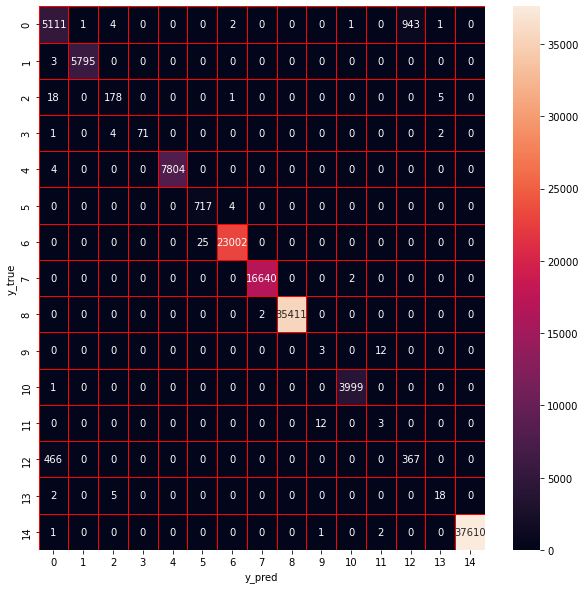

In [ ]:
rf_score = rf_model.score(X_test_rf,y_test_rf)
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_test_rf, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_test_rf,y_predict))
cm=confusion_matrix(y_test_rf,y_predict)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
from sdv.evaluation import evaluate
plt.show()

In [ ]:
score_all = evaluate(data_DoS_attacks_SlowHTTPTest,data_FTP_BruteForce).round(3)
print('Similarity between attack class 9 and 11 %s' % score_all)

Similarity between attack class 9 and 11 0.951


## Exploratory Data Analysis on the Original Imbalanced Dataset:

In [ ]:
df_org = pd.read_csv(directory + 'train_set.csv')

In [ ]:
df_org

,Dst Port,Flow Duration,Tot Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,...,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Idle Min,Label,Binary
0,22,367965,22,2665.0,640.0,88.363636,137.869001,133.250000,268.771254,12525.647820,...,54.352996,42965.631229,0.0,0.0,26883.0,230.0,32.0,0.0,14,1
1,5355,406684,2,0.0,22.0,22.000000,0.000000,0.000000,0.000000,108.192110,...,0.000000,0.000000,0.0,0.0,-1.0,-1.0,8.0,0.0,0,1
2,80,57443,3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,225.0,-1.0,32.0,0.0,8,1
3,53,1834,1,135.0,37.0,37.000000,0.000000,135.000000,0.000000,93784.078517,...,545.256270,3201.333333,0.0,0.0,-1.0,-1.0,8.0,0.0,0,1
4,55950,1444,5,340.0,935.0,187.000000,418.144712,170.000000,240.416306,882963.988900,...,1385.041551,112374.553600,0.0,1.0,65535.0,32768.0,20.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373961,49887,59,2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,32.0,-1.0,20.0,0.0,0,1
373962,22,405356,22,2665.0,640.0,86.909091,137.688022,133.250000,268.771254,11291.309368,...,49.339346,42969.919158,0.0,0.0,26883.0,230.0,32.0,0.0,14,1
373963,22,308887,22,2665.0,640.0,87.636364,137.780552,121.136364,258.641560,14869.515389,...,71.223457,41510.381818,0.0,0.0,26883.0,230.0,32.0,0.0,14,1
373964,8080,9826,3,129.0,326.0,108.666667,188.216188,32.250000,53.767245,46305.719520,...,407.083249,13318.696430,0.0,1.0,8192.0,219.0,20.0,0.0,1,1


In [ ]:
df_org['Binary'] = np.where(df_org['Label']== 0, 0, 1)

In [ ]:
df_org.iloc[:,:-2].describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,623355.000000,623355.000000,6.233550e+05,623355.000000,623355.000000,6.233550e+05,6.233550e+05,623355.000000,623355.000000,623355.000000,...,623355.000000,623355.000000,6.233550e+05,6.233550e+05,6.233550e+05,6.233550e+05,6.233550e+05,6.233550e+05,6.233550e+05,6.233550e+05
mean,6080.630949,7.397457,9.094794e+06,349.940414,7.709990,1.161190e+04,3.571318e+03,269.040141,6.135247,58.110945,...,346.111192,23.256135,1.568694e+05,6.733917e+04,2.224949e+05,1.115658e+05,6.173086e+06,1.019078e+06,8.456585e+06,4.849422e+06
std,15744.469617,3.782398,1.054718e+09,6531.792648,150.263854,2.098732e+05,2.173617e+05,313.756139,24.127523,62.751619,...,6531.803338,8.516789,1.940527e+06,1.135023e+06,2.567984e+06,1.627372e+06,6.182986e+08,4.232020e+08,1.716920e+09,1.720543e+07
min,0.000000,0.000000,-6.420520e+11,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,6.000000,1.346300e+04,2.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,6.000000,3.603130e+05,3.000000,3.000000,9.000000e+01,2.320000e+02,52.000000,0.000000,44.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,6.000000,4.083365e+06,9.000000,7.000000,1.022000e+03,1.581000e+03,640.000000,0.000000,89.818182,...,5.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65531.000000,17.000000,1.200000e+08,309629.000000,69241.000000,9.908128e+06,1.010000e+08,34368.000000,1460.000000,7303.306914,...,309628.000000,56.000000,1.110665e+08,6.500000e+07,1.110665e+08,1.110665e+08,3.560329e+11,2.377517e+11,9.684340e+11,4.908000e+09


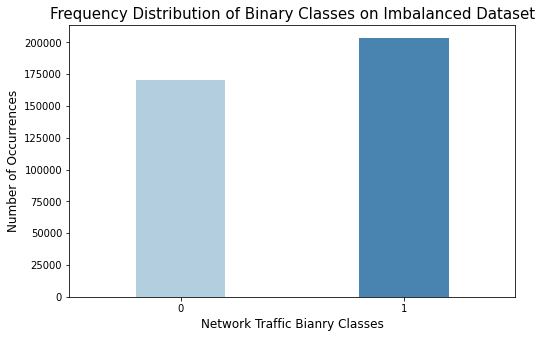

In [ ]:
f, ax = plt.subplots(figsize=(8, 5))
sns.countplot(x="Binary", data=df_org, palette="Blues", width = 0.4)
plt.title('Frequency Distribution of Binary Classes on Imbalanced Dataset', fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Network Traffic Bianry Classes', fontsize=12)
plt.show()

In [ ]:
#Examine the class label imbalance
normal, attack = np.bincount(df_org['Binary'])
total = normal + attack
print('Examples:\n    Total: {}\n    Attack: {} ({:.2f}% of total)\n'.format(
    total, attack, 100 * attack / total))

Examples:
    Total: 373966
    Attack: 203578 (54.44% of total)



In [ ]:
df_org.loc[df_org['Label']==0,'Label_name'] = 'Benign'
df_org.loc[df_org['Label']==1,'Label_name'] = 'Bot'
df_org.loc[df_org['Label']==2,'Label_name'] = 'Brute Force -Web'
df_org.loc[df_org['Label']==3,'Label_name'] = 'Brute Force -XSS'
df_org.loc[df_org['Label']==4,'Label_name'] = 'DDOS attack-HOIC'
df_org.loc[df_org['Label']==5,'Label_name'] = 'DDOS attack-LOIC-UDP'
df_org.loc[df_org['Label']==6,'Label_name'] = 'DDoS attacks-LOIC-HTTP'
df_org.loc[df_org['Label']==7,'Label_name'] = 'DoS attacks-GoldenEye'
df_org.loc[df_org['Label']==8,'Label_name'] = 'DoS attacks-Hulk'
df_org.loc[df_org['Label']==9,'Label_name'] = 'DoS attacks-SlowHTTPTest'
df_org.loc[df_org['Label']==10,'Label_name'] = 'DoS attacks-Slowloris'
df_org.loc[df_org['Label']==11,'Label_name'] = 'FTP-BruteForce'
df_org.loc[df_org['Label']==12,'Label_name'] = 'Infilteration'
df_org.loc[df_org['Label']==13,'Label_name'] = 'SQL Injection'
df_org.loc[df_org['Label']==14,'Label_name'] = 'SSH-Bruteforce'

In [ ]:
counts = pd.Series(df_org.Label_name.value_counts(dropna=False).tolist())
class_names = pd.Series(df_org.Label_name.value_counts().keys().tolist())
label_counts = dict(zip(class_names, counts))
percs = pd.Series((df_org.Label_name.value_counts(normalize=True).mul(100).round(3).astype(str)+ '%').tolist())
class_dis = pd.DataFrame(data=label_counts.items(), columns=['Class labels', 'Count'])
class_dis['Percentage'] = percs
class_dis


,Class labels,Count,Percentage
0,Benign,170388,45.562%
1,SSH-Bruteforce,56433,15.09%
2,DoS attacks-Hulk,53273,14.245%
3,DDoS attacks-LOIC-HTTP,34584,9.248%
4,DoS attacks-GoldenEye,24762,6.621%
5,DDOS attack-HOIC,11769,3.147%
6,Bot,8650,2.313%
7,Infilteration,6587,1.761%
8,DoS attacks-Slowloris,5906,1.579%
9,DDOS attack-LOIC-UDP,1009,0.27%


In [ ]:
counts = pd.Series(df_org.Binary.value_counts(ascending=True, dropna=False).tolist())
binary_class = pd.Series(df_org.Binary.value_counts(ascending=True).keys().tolist())

B_label_counts = dict(zip(binary_class,counts))
percs = pd.Series((df_org.Binary.value_counts(normalize=True, ascending=True).mul(100).round(1).astype(str)+ '%').tolist())
B_class_dis = pd.DataFrame(data=B_label_counts.items(), columns=['Binary class', 'Count'])
B_class_dis['Percentage'] = percs
B_class_dis['Binary class'] = np.where(B_class_dis['Binary class']== 0, 'Benign', 'Malicious')
B_class_dis.reset_index(drop=True)

,Binary class,Count,Percentage
0,Benign,170388,45.6%
1,Malicious,203578,54.4%


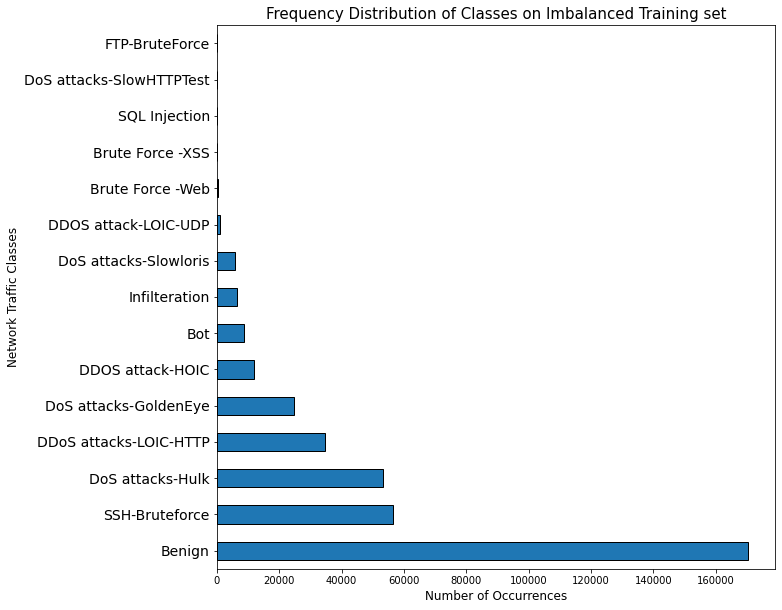

In [ ]:
#horizontal bar chart
df_org['Label_name'].value_counts().plot.barh(x='Label_name', edgecolor='black', figsize = (10,10))
plt.title('Frequency Distribution of Classes on Imbalanced Training set', fontsize=15)
plt.yticks(fontsize=14)
plt.ylabel('Network Traffic Classes', fontsize=12)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.show()

## Exploratory Data Analysis on the Balanced Dataset:

In [ ]:

# Loading the balanced dataset
df = pd.read_csv(directory + 'train_balanced.csv')


In [ ]:
    
df.loc[df['Label']==0,'Label_name'] = 'Benign'
df.loc[df['Label']==1,'Label_name'] = 'Bot'
df.loc[df['Label']==2,'Label_name'] = 'Brute Force -Web'
df.loc[df['Label']==3,'Label_name'] = 'Brute Force -XSS'
df.loc[df['Label']==4,'Label_name'] = 'DDOS attack-HOIC'
df.loc[df['Label']==5,'Label_name'] = 'DDOS attack-LOIC-UDP'
df.loc[df['Label']==6,'Label_name'] = 'DDoS attacks-LOIC-HTTP'
df.loc[df['Label']==7,'Label_name'] = 'DoS attacks-GoldenEye'
df.loc[df['Label']==8,'Label_name'] = 'DoS attacks-Hulk'
df.loc[df['Label']==9,'Label_name'] = 'DoS attacks-SlowHTTPTest'
df.loc[df['Label']==10,'Label_name'] = 'DoS attacks-Slowloris'
df.loc[df['Label']==11,'Label_name'] = 'FTP-BruteForce'
df.loc[df['Label']==12,'Label_name'] = 'Infilteration'
df.loc[df['Label']==13,'Label_name'] = 'SQL Injection'
df.loc[df['Label']==14,'Label_name'] = 'SSH-Bruteforce'

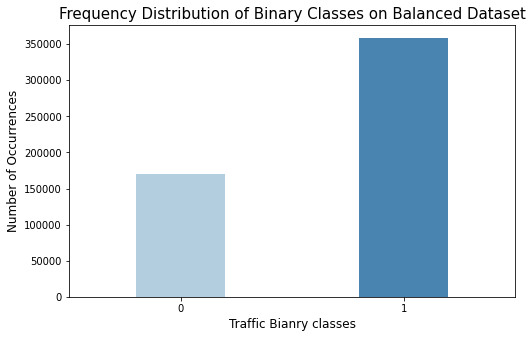

In [ ]:
f, ax = plt.subplots(figsize=(8, 5))
sns.countplot(x="Binary", data=df, palette="Blues", width = 0.4)
plt.title('Frequency Distribution of Binary Classes on Balanced Dataset', fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Traffic Bianry classes', fontsize=12)
plt.show()

In [ ]:
counts = pd.Series(df.Label_name.value_counts(dropna=False).tolist())
class_names = pd.Series(df.Label_name.value_counts().keys().tolist())
label_counts = dict(zip(class_names, counts))
percs = pd.Series((df.Label_name.value_counts(normalize=True).mul(100).round(1).astype(str)+ '%').tolist())
class_dis = pd.DataFrame(data=label_counts.items(), columns=['Class labels', 'Count'])
class_dis['Percentage'] = percs
class_dis


,Class labels,Count,Percentage
0,Benign,170388,32.2%
1,SSH-Bruteforce,56433,10.7%
2,DoS attacks-Hulk,53273,10.1%
3,DDoS attacks-LOIC-HTTP,34584,6.5%
4,DoS attacks-GoldenEye,24762,4.7%
5,DDOS attack-HOIC,21769,4.1%
6,DoS attacks-Slowloris,20906,4.0%
7,Brute Force -XSS,20150,3.8%
8,SQL Injection,20058,3.8%
9,DoS attacks-SlowHTTPTest,20040,3.8%


In [ ]:
counts = pd.Series(df.Binary.value_counts(ascending=True, dropna=False).tolist())
binary_class = pd.Series(df.Binary.value_counts(ascending=True).keys().tolist())

B_label_counts = dict(zip(binary_class,counts))
percs = pd.Series((df.Binary.value_counts(normalize=True, ascending=True).mul(100).round(1).astype(str)+ '%').tolist())
B_class_dis = pd.DataFrame(data=B_label_counts.items(), columns=['Binary class', 'Count'])
B_class_dis['Percentage'] = percs
B_class_dis['Binary class'] = np.where(B_class_dis['Binary class']== 0, 'Benign', 'Malicious')
B_class_dis.reset_index(drop=True)

,Binary class,Count,Percentage
0,Benign,170388,32.2%
1,Malicious,358578,67.8%


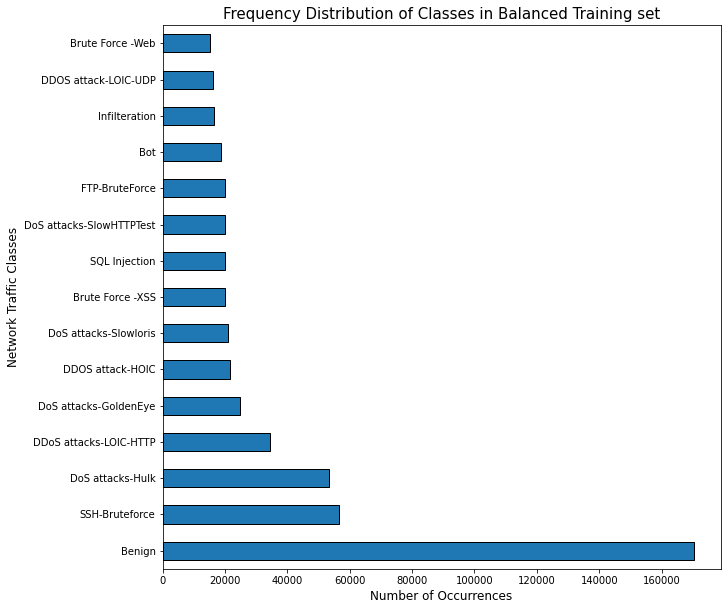

In [ ]:
#horizontal bar chart
df['Label_name'].value_counts().plot.barh(x='Class labels', edgecolor='black', figsize = (10,10))
plt.title('Frequency Distribution of Classes in Balanced Training set', fontsize=15)
plt.ylabel('Network Traffic Classes', fontsize=12)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.show()

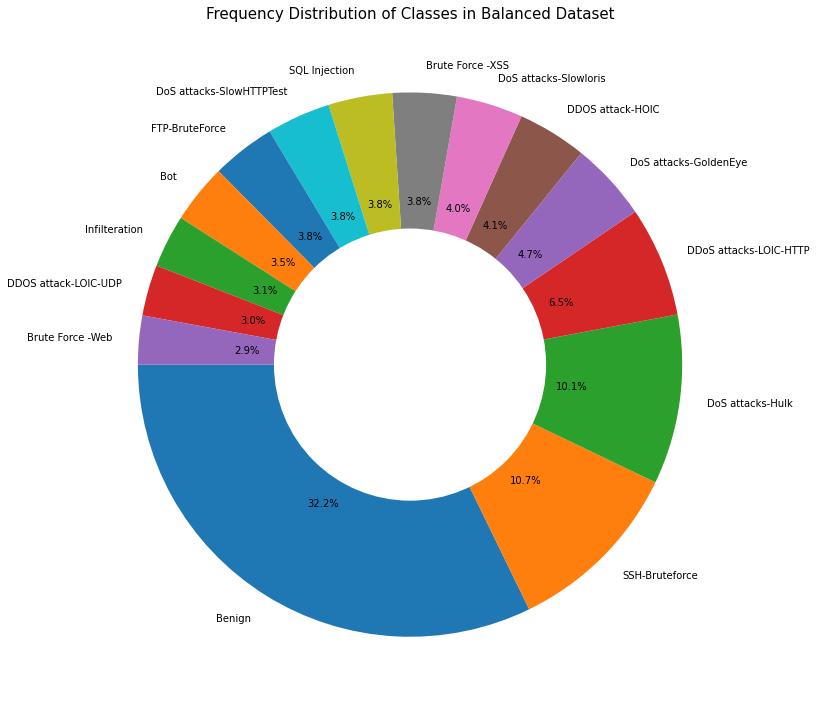

In [ ]:
# pie Chart
plt.figure(figsize=(18,10))
plt.title('Frequency Distribution of Classes in Balanced Dataset', fontsize=15)
label_c = df['Label_name'].value_counts() 
plt.pie(label_c, labels=label_c.index, autopct='%1.1f%%', startangle=180)
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.show()

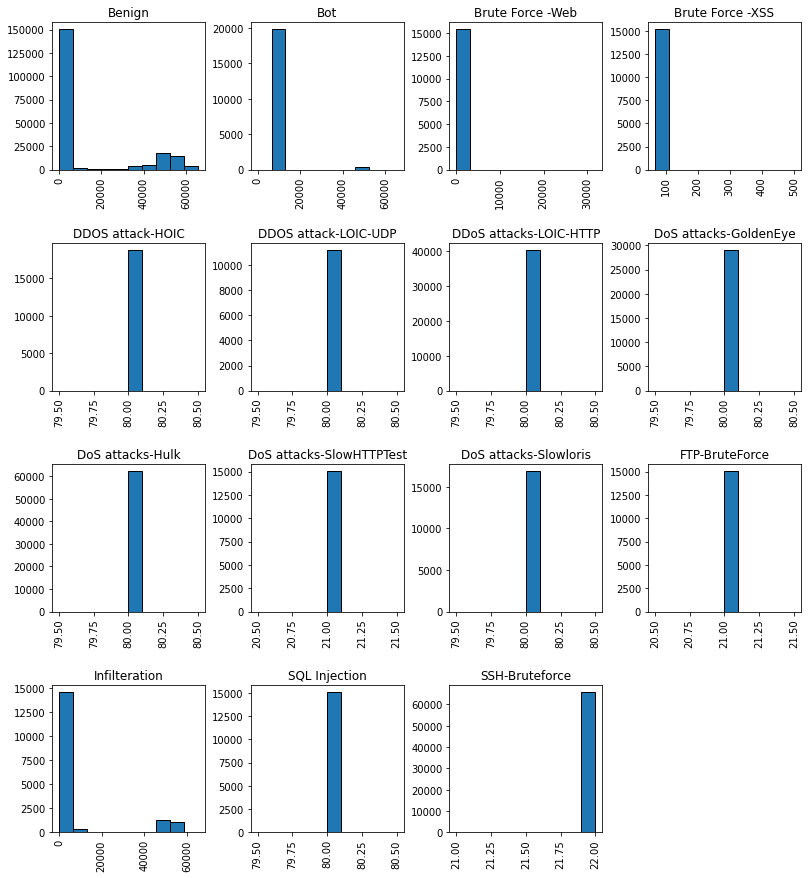

In [ ]:

df['Dst Port'].hist(by=df['Label_name'], edgecolor='black', figsize = (13,15)) 
plt.title('Frequency Distribution of Classes')
plt.xlabel('Destination Ports')
plt.ylabel('Frequency')
plt.show()

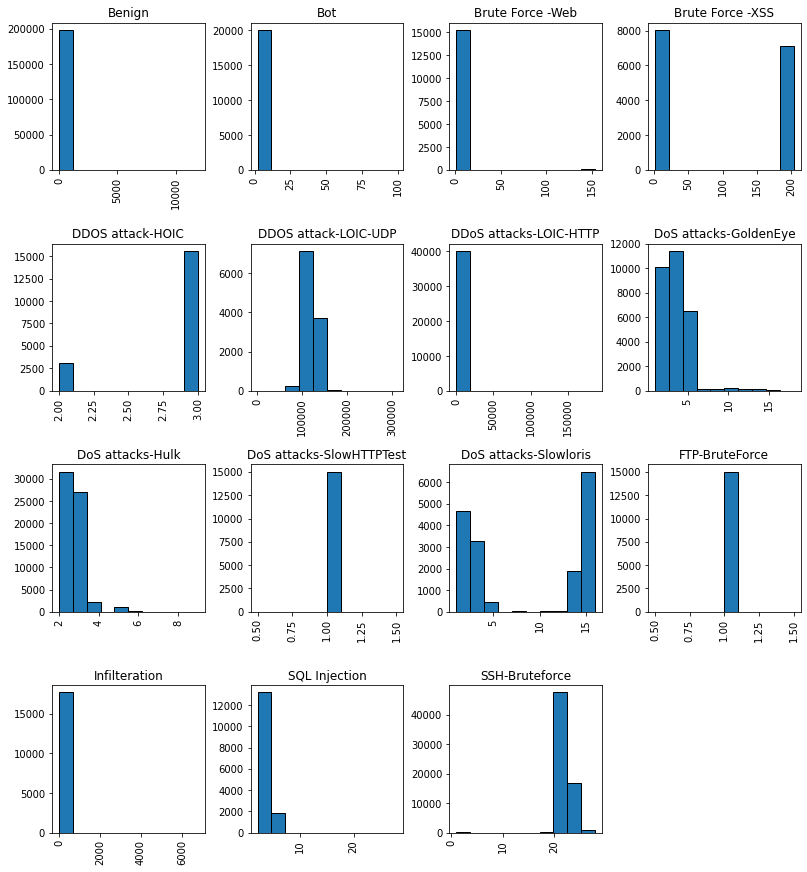

In [ ]:
df['Tot Fwd Pkts'].hist(by=df['Label_name'], edgecolor='black', figsize = (13,15)) 
plt.title('Total forward Packets by Class Label')
plt.xlabel('Total forward Packets')
plt.ylabel('Frequency')
plt.show()